In [1]:
import sys
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import distance

sys.path.append("..")
import geoobb.obb as obb

## Load Data


4000 records returned


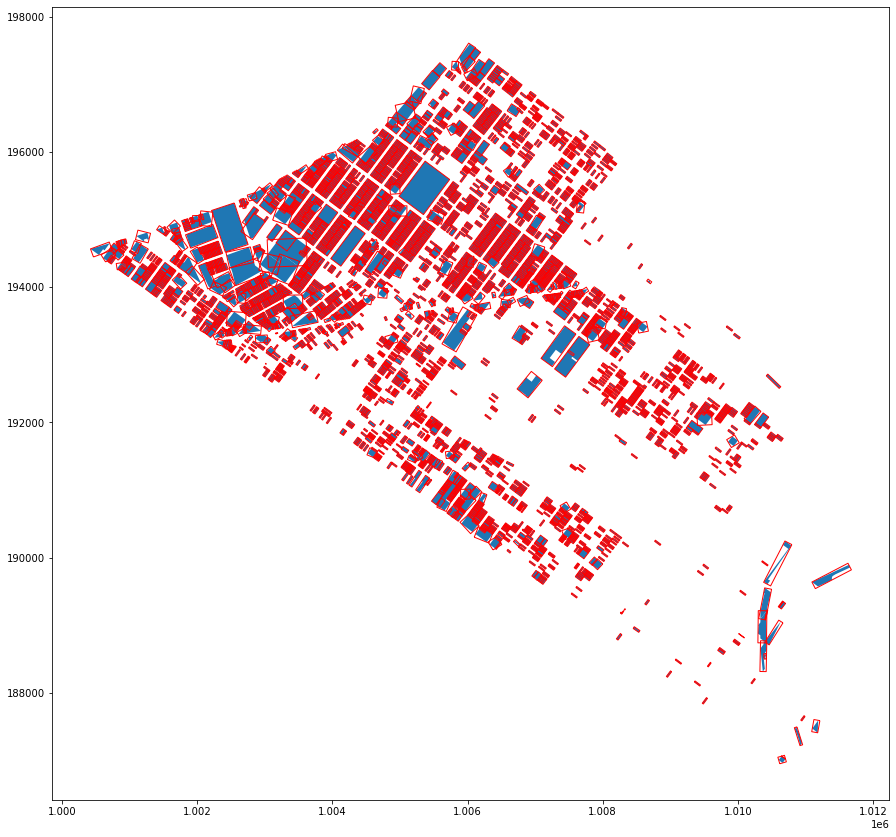

In [2]:
api_url = r'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/MAPPLUTO/FeatureServer/0/query'

params = {
    'where': 'CD = 304',
    'f': 'pgeojson',
    'outFields': 'BBL',
}

r = requests.get(api_url, params=params)

gdf = gpd.read_file(r.text, driver='GeoJSON')
gdf['BBL'] = gdf.BBL.astype(str)
gdf.to_crs(epsg=2263, inplace=True)

# the api has a max record limit of 4000
print(f'{len(gdf)} records returned')

# Generate OBBs

convex_hull_arrs = gdf.geometry.convex_hull.map(obb.geom_to_array)
obbs = convex_hull_arrs.apply(obb.oriented_bounding_box)

obbs_gs = gpd.GeoSeries(obbs.map(obb.polygon_from_obb), crs=gdf.crs)
ax = gdf.plot(figsize=(15, 15))
obbs_gs.plot(ax=ax, linewidth=1, edgecolor='red', facecolor='none');

## Block Orientation KMeans Elbow Analysis


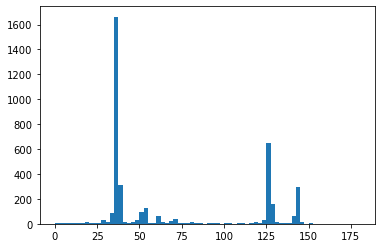

In [3]:
angles = np.array([obb.obb_angle(o) for o in obbs])
abs_angles = np.abs(angles)

plt.hist(np.degrees(abs_angles), bins=np.arange(0, 182.5, 2.5));

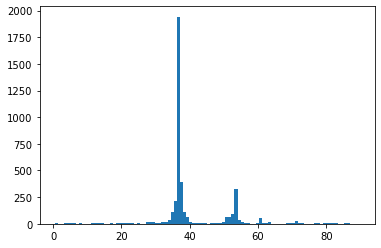

In [4]:
plt.hist(np.degrees(abs_angles) % 90, bins=100);

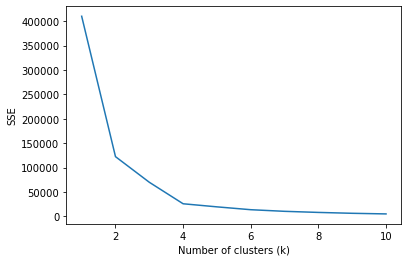

In [5]:
data = (np.degrees(abs_angles) % 90).reshape(-1, 1)

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

Centers:  [[35.9096564 ]
 [56.57669895]]


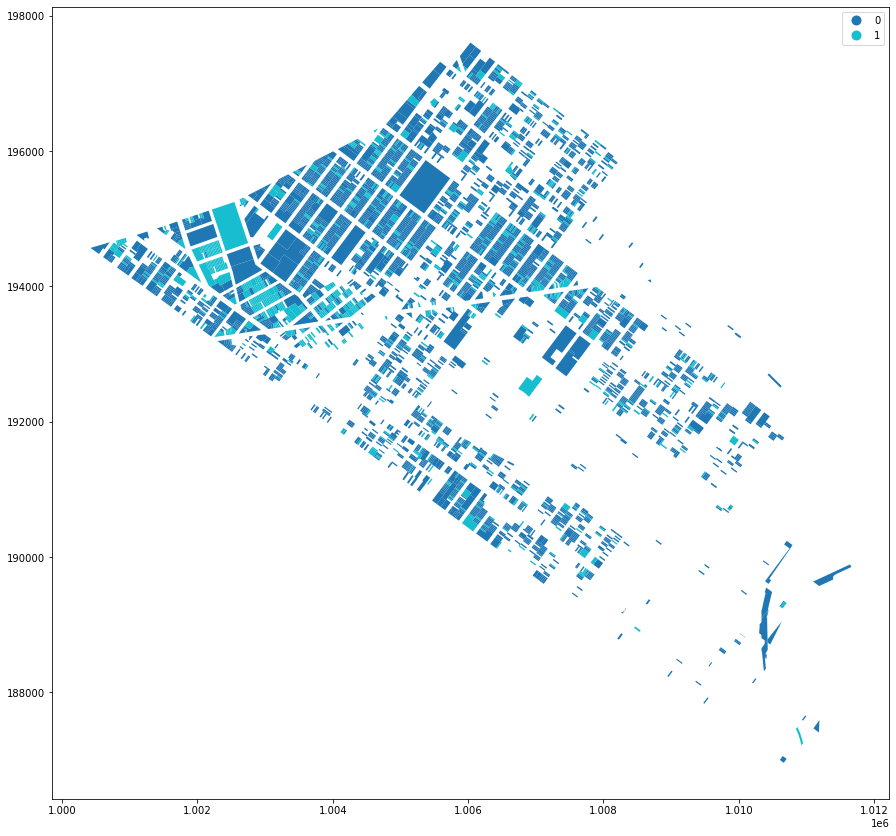

In [6]:
optimal_k = 2

kmeans = KMeans(n_clusters=optimal_k, max_iter=1000)
kmeans.fit(data)

print('Centers: ', kmeans.cluster_centers_)

gdf['cluster'] = kmeans.labels_
gdf.plot(column='cluster', figsize=(15, 15), legend=True, categorical=True);

## With Distance Threshold


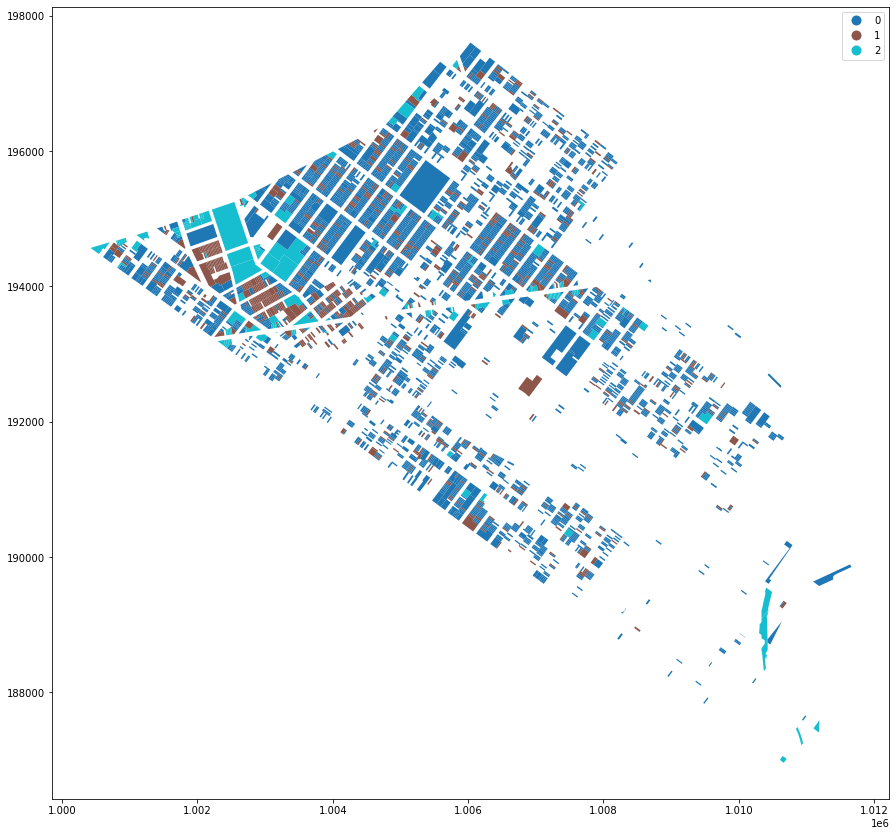

In [7]:
distance_threshold = 15

distances_to_center = np.min(distance.cdist(data, kmeans.cluster_centers_, 'euclidean'), axis=1)
labels = np.where(distances_to_center > distance_threshold, optimal_k, kmeans.labels_)

gdf['cluster_w_dist_threshold'] = labels
gdf.plot(column='cluster_w_dist_threshold', figsize=(15, 15), legend=True, categorical=True);

## By Tax Block


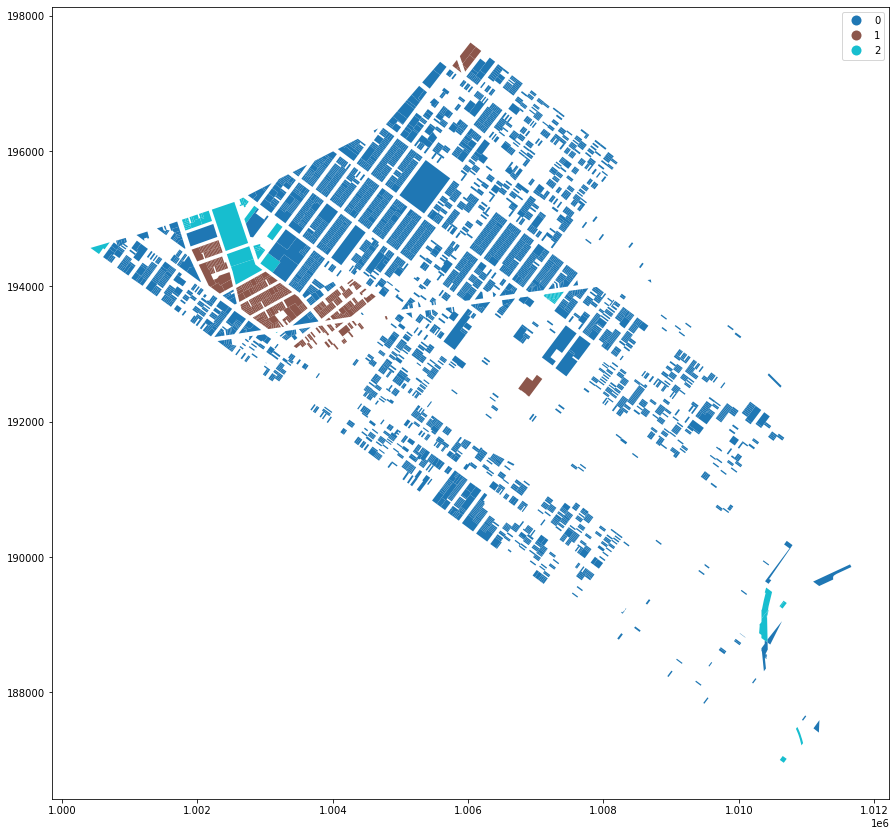

In [8]:
gdf['tax_block'] = gdf['BBL'].str.slice(1, 6)
# Get most frequent cluster for each tax block
block_cluster = pd.DataFrame(gdf.groupby('tax_block').cluster_w_dist_threshold.agg(block_cluster=lambda x: pd.Series.mode(x)[0])).reset_index()

# Get most frequent cluster for each cluster
gdf = pd.merge(gdf, block_cluster, on='tax_block')
gdf.plot(column='block_cluster', figsize=(15, 15), legend=True, categorical=True);